<a href="https://colab.research.google.com/github/manurajvanamala/classsification/blob/main/pdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_dir = "/content/drive/MyDrive/pdp_course/group/dataset"

In [ ]:
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/training")
print(len(classes),'classes :', classes)

Folders : ['validation', 'training']
3 classes : ['Tiger', 'Hyena', 'Cheetah']


In [ ]:
dataset = ImageFolder(data_dir + '/training', transform=ToTensor())
print('Size of training dataset :', len(dataset))

Size of training dataset : 2700


In [ ]:
test = ImageFolder(data_dir + '/validation', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of test dataset : 300


In [ ]:
img, label = dataset[0]
print(img.shape)


torch.Size([3, 400, 400])


In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "(" + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))


Label:  Cheetah (0)


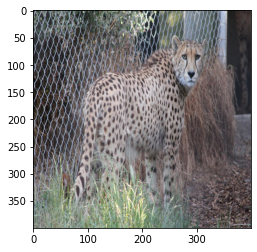

In [ ]:
show_example(*dataset[0])

Label:  Tiger (2)


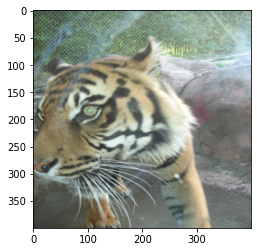

In [ ]:
show_example(*dataset[2020])

Label:  Hyena (1)


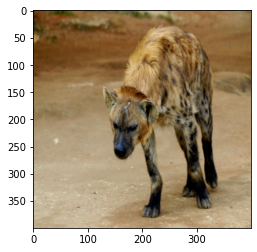

In [ ]:
show_example(*dataset[1233])

In [ ]:
torch.manual_seed(43)
val_size = 300
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)


(2400, 300)

In [ ]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


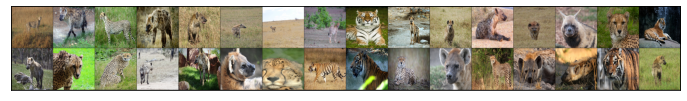

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.is_available()

False

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*400*400
output_size = 3

In [ ]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.out_layer = nn.Linear(16, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [ ]:
model = to_device(Model(input_size, output_size), device)

In [ ]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.34062498807907104, 'val_loss': 1.0997869968414307}]

In [ ]:
history += fit(3, 0.05, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.0998, val_acc: 0.3423
Epoch [1], val_loss: 1.1358, val_acc: 0.3259
Epoch [2], val_loss: 1.0858, val_acc: 0.3455


In [ ]:
history += fit(10, 0.001, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.0803, val_acc: 0.3847
Epoch [1], val_loss: 1.0785, val_acc: 0.4065
Epoch [2], val_loss: 1.0767, val_acc: 0.3977
Epoch [3], val_loss: 1.0752, val_acc: 0.3991
Epoch [4], val_loss: 1.0734, val_acc: 0.4134
Epoch [5], val_loss: 1.0719, val_acc: 0.4270
Epoch [6], val_loss: 1.0702, val_acc: 0.4210
Epoch [7], val_loss: 1.0688, val_acc: 0.4074
Epoch [8], val_loss: 1.0674, val_acc: 0.4293
Epoch [9], val_loss: 1.0660, val_acc: 0.4369


In [ ]:
history += fit(10, 0.02, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.0598, val_acc: 0.4474
Epoch [1], val_loss: 1.1125, val_acc: 0.3645
Epoch [2], val_loss: 1.0678, val_acc: 0.4364
Epoch [3], val_loss: 1.1183, val_acc: 0.3903
Epoch [4], val_loss: 1.0458, val_acc: 0.4889
Epoch [5], val_loss: 1.0519, val_acc: 0.4315
Epoch [6], val_loss: 1.0398, val_acc: 0.4935
Epoch [7], val_loss: 1.0381, val_acc: 0.4841
Epoch [8], val_loss: 1.0341, val_acc: 0.4281
Epoch [9], val_loss: 1.0423, val_acc: 0.4733


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

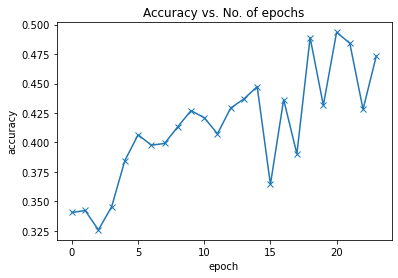

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

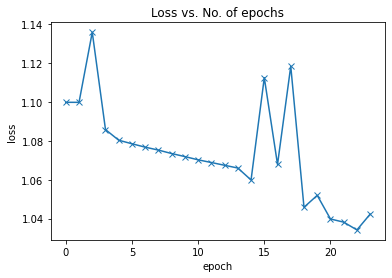

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.5244318246841431, 'val_loss': 0.9836908578872681}